In [1]:
setwd("..")

In [27]:
library(dplyr)
library(janitor)
library(purrr)
library(readr)
library(ggplot2)
library(tidyr)
library(ggpubr)
source("~/github/2022-microberna/scripts/utils.R")

## Download and read in GTDB rs202 metadata

In [4]:
destfile <- "inputs/gtdb/bac120_metadata_r202.tar.gz"
url <- "https://data.ace.uq.edu.au/public/gtdb/data/releases/release202/202.0/bac120_metadata_r202.tar.gz"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
outfile <- "inputs/gtdb/bac120_metadata_r202.tsv"
if (!file.exists(outfile)){
  untar(destfile, exdir = "inputs/gtdb")
}

destfile <- "inputs/gtdb/ar122_metadata_r202.tar.gz"
url <- "https://data.ace.uq.edu.au/public/gtdb/data/releases/release202/202.0/ar122_metadata_r202.tar.gz"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
outfile <- "inputs/gtdb/ar122_metadata_r202.tsv"
if (!file.exists(outfile)){
  untar(destfile, exdir = "inputs/gtdb")
}

In [21]:
gtdb_metadata <- read_tsv("inputs/gtdb/bac120_metadata_r202.tsv", show_col_types = F) %>%
  separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
           sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("GB_", "", accession)) %>%
  mutate(accession = gsub("RS_", "", accession))

gtdb_metadata <- read_tsv("inputs/gtdb/ar122_metadata_r202.tsv", show_col_types = F) %>%
  separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
           sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("GB_", "", accession)) %>%
  mutate(accession = gsub("RS_", "", accession)) %>%
  bind_rows(gtdb_metadata)

Warning message:
“One or more parsing issues, see `problems()` for details”


## Read in charcoal results

In [13]:
charcoal <- read_csv("outputs/gtdb_rs202_charcoal1//stage1_hitlist.csv", show_col_types = F)%>%
  mutate(genome = gsub("_genomic.fna.gz", "", genome))

## Analyze

**Does the charcoal lineage match the gtdb lineage?**

Yes.

In [39]:
gtdb_metadata <- gtdb_metadata %>%
  mutate(order_lineage = paste(sep = ";", domain, phylum, class, order))

combined <- left_join(charcoal, gtdb_metadata, by = c("genome" = "accession")) %>%
  mutate(lineages_match = ifelse(lineage == order_lineage, T, F),
         charcoal_contamination_order = (order_bad_bp/genome_size)*100,
         charcoal_contamination_family = (family_bad_bp/genome_size)*100,
         charcoal_contamination_genus = (genus_bad_bp/genome_size)*100,
         contaminated_at_filter_rank = ifelse(order_bad_bp > 0, T, F))

In [33]:
table(combined$lineages_match)
# the missing observations are from when charcoal$lineages == NA. 
# occurs when "All genome hashes belong to one lineage! Nothing to do."


TRUE 
9499 

**Does the checkm contamination estimation match the charcoal-detected contamination?**
Note: `total_bp` would be useful here to be able to estimate percent contamination

It's not super well correlated, but order-level contamination estimates seem to be the ones with the highest correlation

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


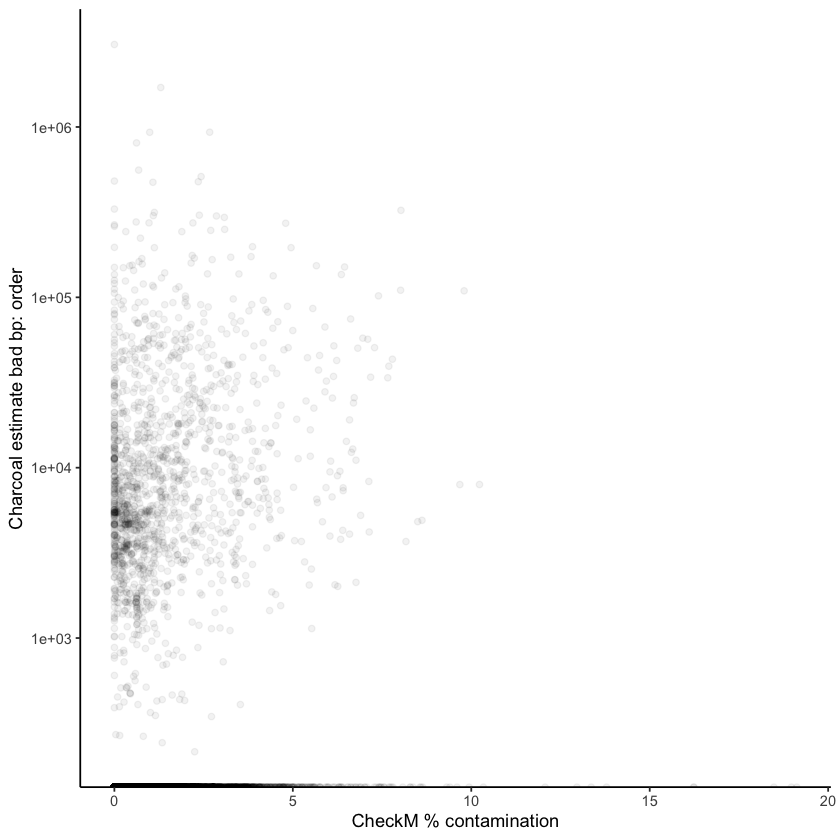

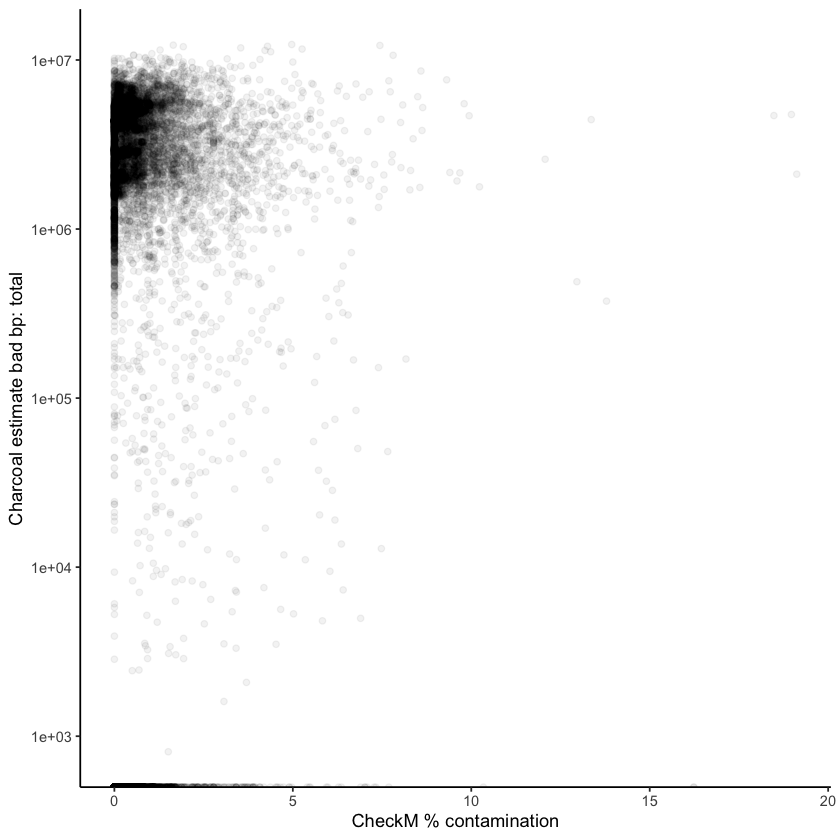

In [24]:
ggplot(combined, aes(x = checkm_contamination, y = order_bad_bp)) +
  geom_point(alpha = 0.05) +
  theme_classic() +
  scale_y_log10() +
  labs(x = "CheckM % contamination", y = "Charcoal estimate bad bp: order")

ggplot(combined, aes(x = checkm_contamination, y = genus_bad_bp)) +
  geom_point(alpha = 0.05) +
  theme_classic() +
  scale_y_log10() +
  labs(x = "CheckM % contamination", y = "Charcoal estimate bad bp: total")

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 11542 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 11542 rows containing non-finite values (stat_smooth).”


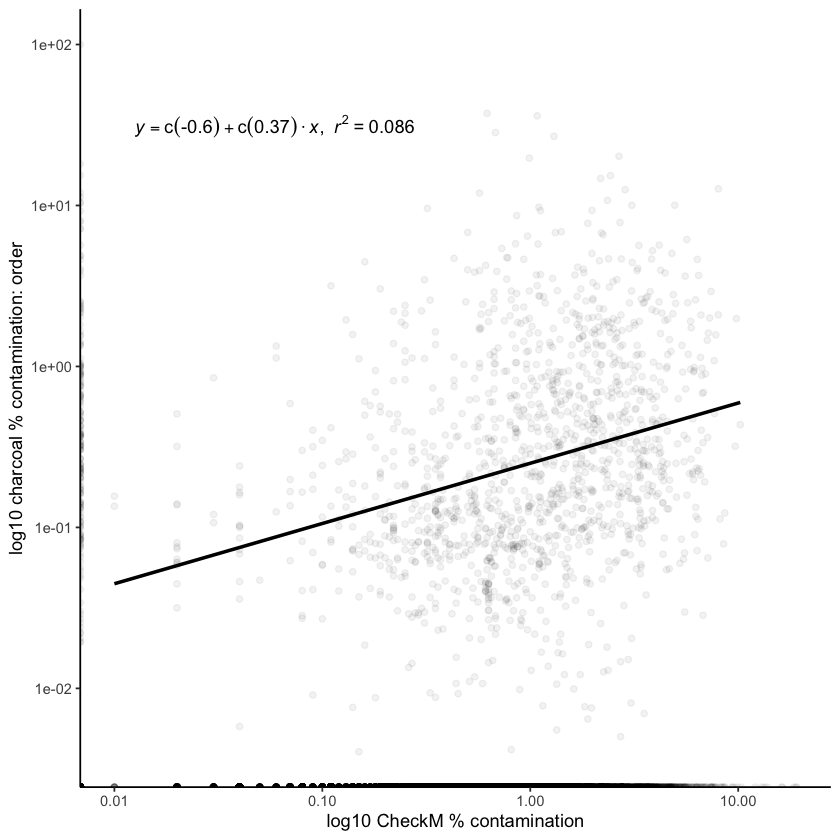

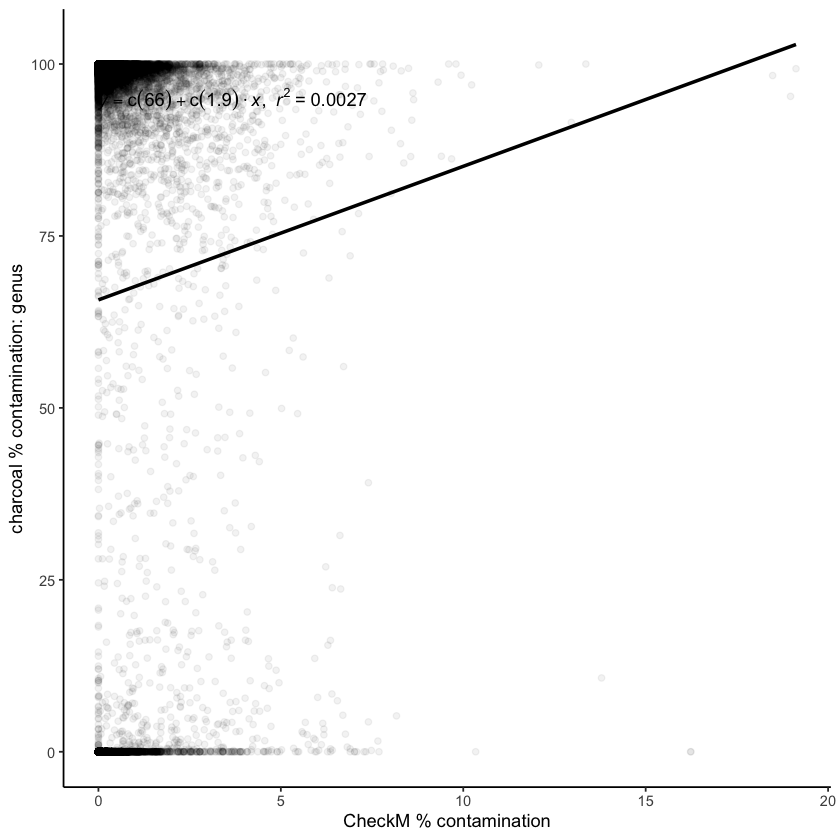

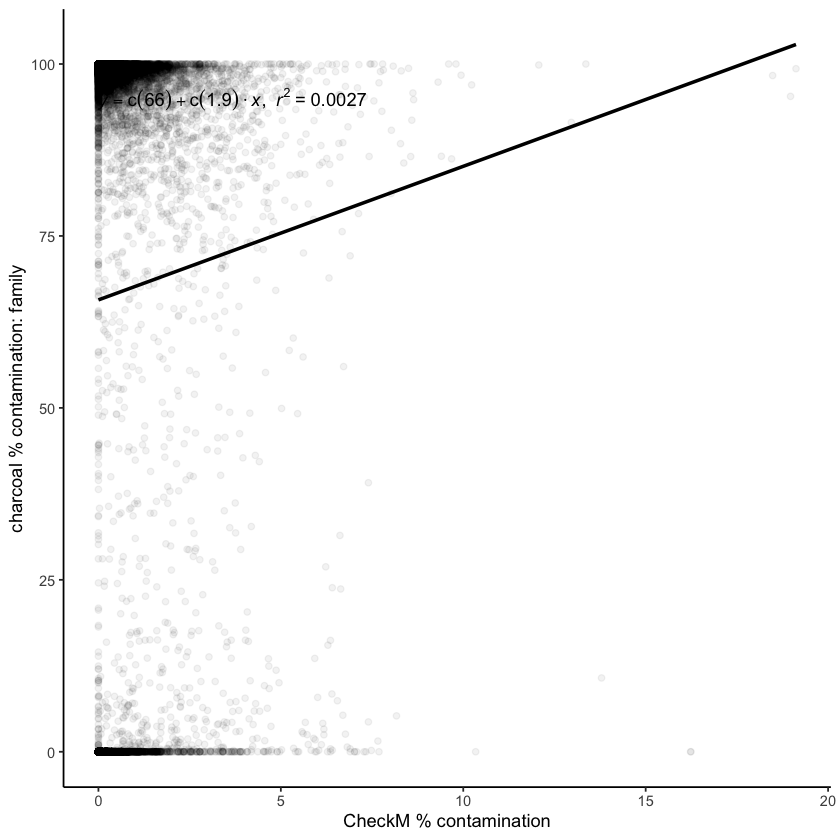

In [40]:
ggplot(combined, aes(x = checkm_contamination, y = charcoal_contamination_order)) +
  geom_point(alpha = 0.05) +
  theme_classic() +
  labs(x = "log10 CheckM % contamination", y = "log10 charcoal % contamination: order") +
  scale_y_log10() +
  scale_x_log10() +
  stat_smooth_func(geom = 'text', method = 'lm', hjust = 0, parse = T) +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x)

ggplot(combined, aes(x = checkm_contamination, y = charcoal_contamination_genus)) +
  geom_point(alpha = 0.05) +
  theme_classic() +
  labs(x = "CheckM % contamination", y = "charcoal % contamination: genus") +
  stat_smooth_func(geom = 'text', method = 'lm', hjust = 0, parse = T) +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x)

ggplot(combined, aes(x = checkm_contamination, y = charcoal_contamination_family)) +
  geom_point(alpha = 0.05) +
  theme_classic() +
  labs(x = "CheckM % contamination", y = "charcoal % contamination: family") +
  stat_smooth_func(geom = 'text', method = 'lm', hjust = 0, parse = T) +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x)

**how many genomes were contaminated?**


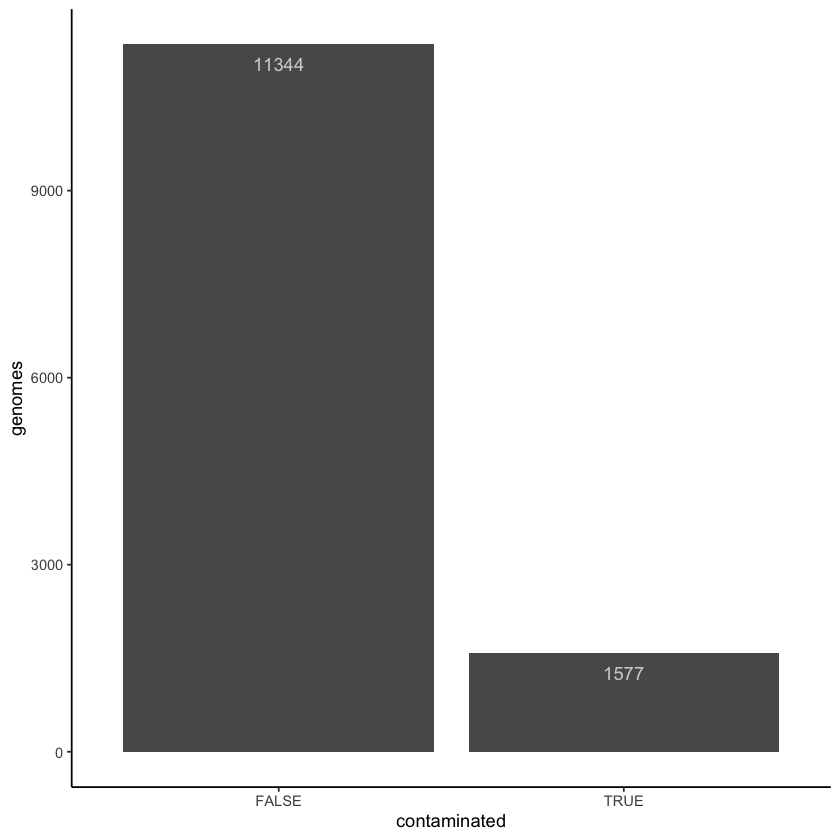

In [41]:
ggplot(combined, aes(x = contaminated_at_filter_rank, label = stat(count))) +
  geom_bar() +
  geom_text(stat = 'count', vjust = 2, color = "lightgrey") +
  theme_classic() +
  labs(y = "genomes", x = "contaminated")

**are genomes that are contaminated less likely to be representative sequences?**

Tells us that FALSE contamination is associated with FALSE GTDB and that TRUE contamination is associated with TRUE GTDB

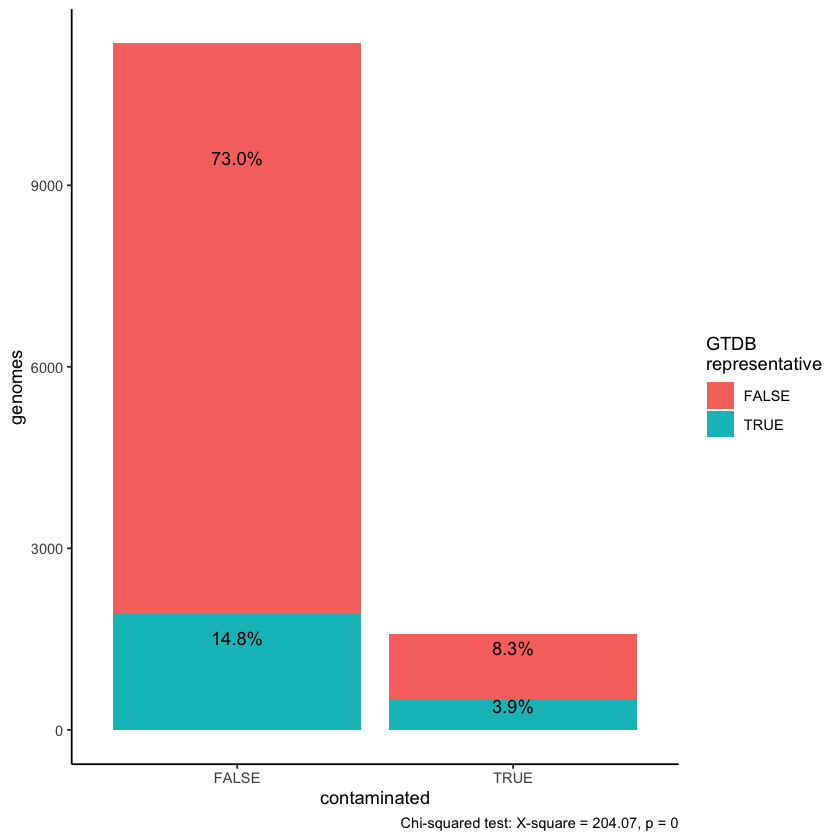

In [43]:
chi_sq_gtdb_rep <- combined %>% 
  group_by(contaminated_at_filter_rank) %>% 
  ungroup %>%
  summarise(pval = chisq.test(contaminated_at_filter_rank, gtdb_representative)$p.value,
            x_squared = chisq.test(contaminated_at_filter_rank, gtdb_representative)$statistic)

ggplot(combined, aes(x = contaminated_at_filter_rank, fill = gtdb_representative,
                     label = scales::percent(prop.table(stat(count))))) +
  geom_bar() + 
  theme_classic() +
  geom_text(stat = 'count',
            position = position_stack(.8)) +
  labs(y = "genomes", x = "contaminated", fill = "GTDB\nrepresentative",
    caption = paste0("Chi-squared test: X-square = ", 
                        round(chi_sq_gtdb_rep$x_squared, digits =2), 
                        ", p = ", round(chi_sq_gtdb_rep$pval,digits = 3)))

**are genomes that are contaminated less likely to be RefSeq?**

Tells us that FALSE contamination is associated with RefSeq and TRUE contamination is associated with GenBank

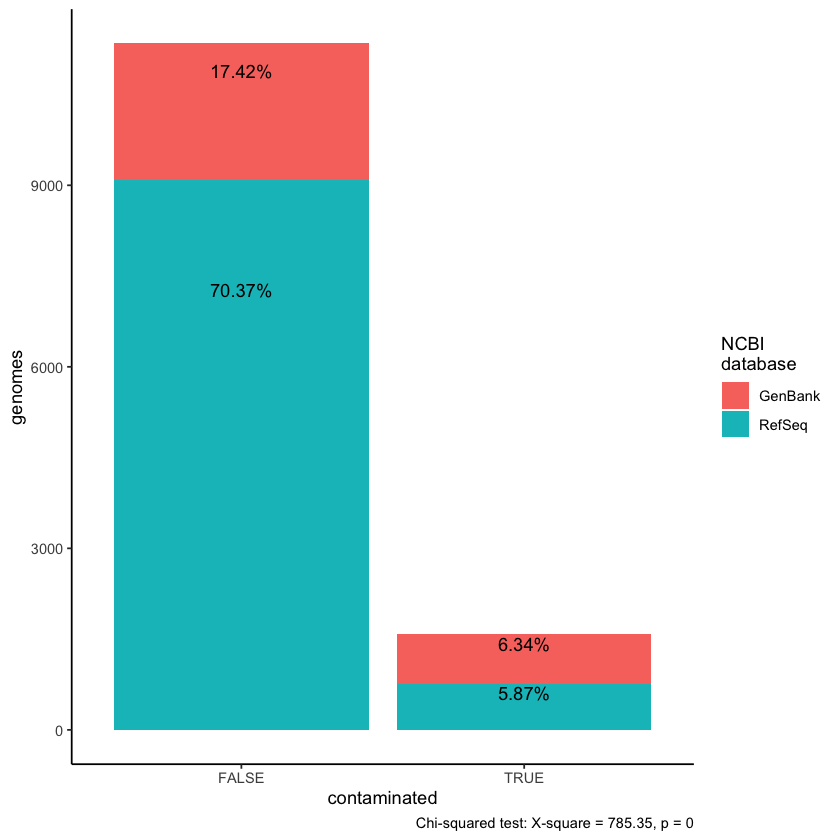

In [44]:
chi_sq_ncbi_db <- combined %>% 
  group_by(contaminated_at_filter_rank) %>% 
  ungroup %>%
  summarise(pval = chisq.test(contaminated_at_filter_rank, ncbi_database)$p.value,
            x_squared = chisq.test(contaminated_at_filter_rank, ncbi_database)$statistic)

ggplot(combined, aes(x = contaminated_at_filter_rank, fill = ncbi_database,
                     label = scales::percent(prop.table(stat(count))))) +
  geom_bar() +
  geom_text(stat = 'count',
            position = position_stack(.8)) +
  theme_classic() +
  labs(y = "genomes", x = "contaminated", fill = "NCBI\ndatabase",
    caption = paste0("Chi-squared test: X-square = ", 
                        round(chi_sq_ncbi_db$x_squared, digits =2), 
                        ", p = ", round(chi_sq_ncbi_db$pval,digits = 3)))

**are genomes with longer contigs less likely to be contaminated?**

Yes

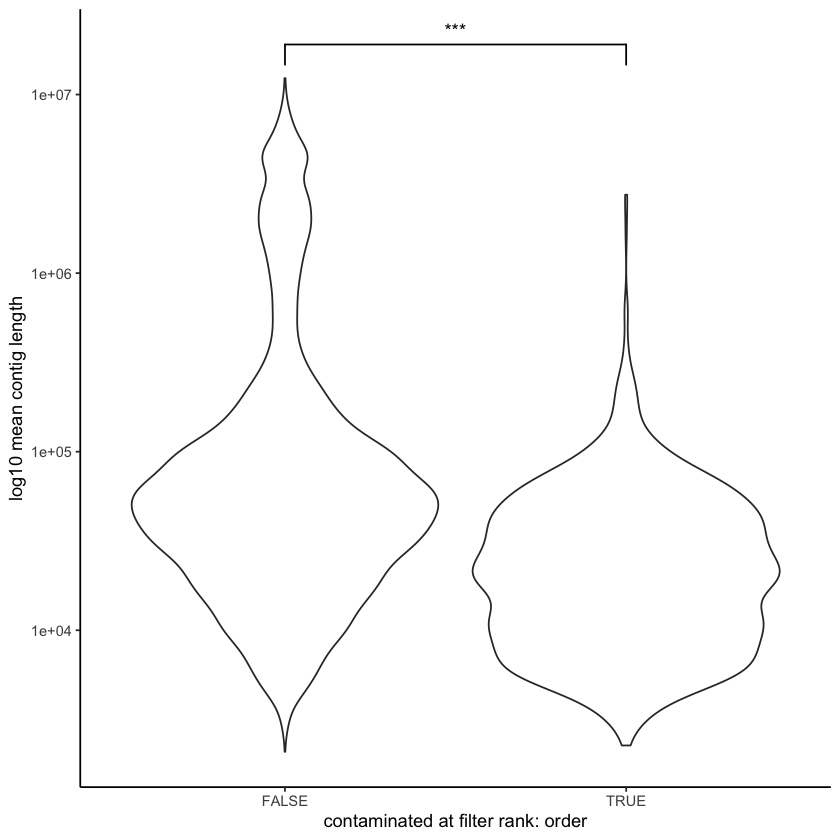

In [45]:
ggplot(combined %>% filter(), aes(x = contaminated_at_filter_rank, y = mean_contig_length)) +
  #geom_boxplot(outlier.alpha = .05) +
  geom_violin() +
  theme_classic() +
  scale_y_log10() +
  geom_signif(comparisons = list(c('TRUE', 'FALSE')), map_signif_level=TRUE) +
  labs(x = "contaminated at filter rank: order", y = "log10 mean contig length")

In [46]:
combined %>%
  group_by(contaminated_at_filter_rank) %>%
  summarize(mean_of_mean_contig_length = mean(mean_contig_length))

contaminated_at_filter_rank,mean_of_mean_contig_length
<lgl>,<dbl>
FALSE,375875.42
TRUE,37629.29


**distribution of contamination across species**

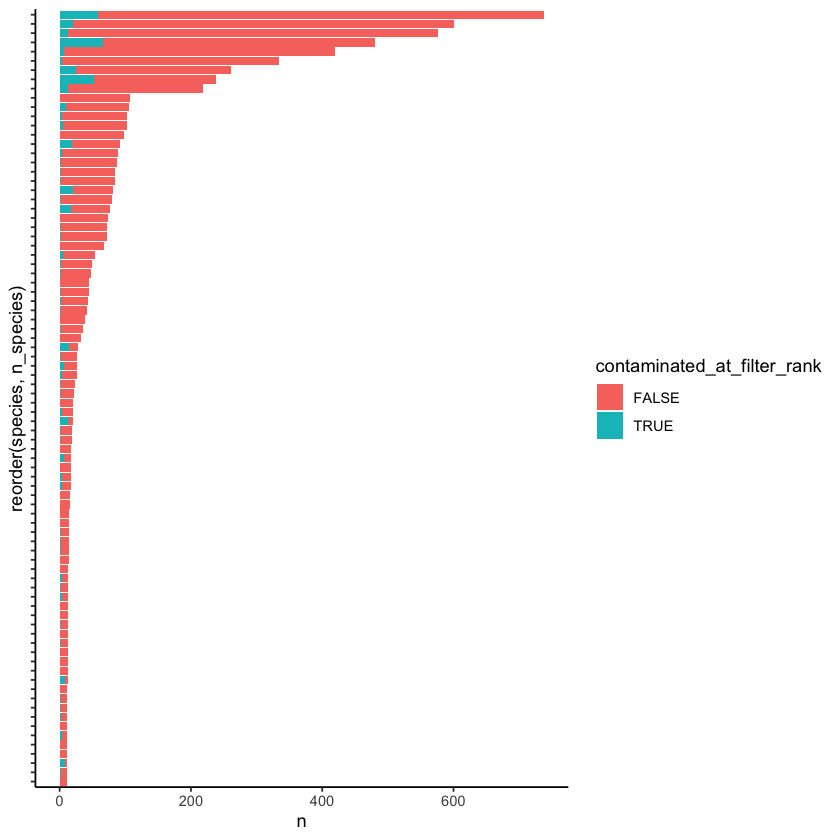

In [47]:
tmp1 <- combined %>%
  group_by(species) %>%
  tally() %>%
  arrange(desc(n)) %>%
  select(species, n_species = n)

tmp2 <- combined %>%
  group_by(contaminated_at_filter_rank, species) %>%
  tally() %>%
  left_join(tmp1, by = "species")


ggplot(tmp2 %>% filter(n_species > 10), 
       aes(x = reorder(species, n_species), y = n, fill = contaminated_at_filter_rank)) +
  geom_col() +
  theme_classic() +
  coord_flip() +
  theme(axis.text.y = element_blank())

## Next Steps

+ explore whether there is a taxonomic bias to the contamination
    + phylosignal may be able to test whether the number of contaminant base pairs or contaminant genomes is distributed disproportionately across taxonomy using GTDB newick tree
+ explore whether genome-contaminant pairs occur more than would be expected by chance